In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def relu_cap(x, b=0):
    return np.clip(x-b, 0, 1)


def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def binary(x, b=0):
    return (x>b).astype(float)

def normalize(x):
    return (x -np.mean(x, axis=1, keepdims=True))/ (1e-8+np.std(x, axis=1, keepdims=True))

def sigmoid(x, b=0):
    return 1 / (1 + np.exp(-(x-b)))

In [3]:
def run_dynamics(W, inputs,  dt=0.1, b=0.0):
    acts = np.zeros([num_states, N_bar])
    for s in range(steps):
        preacts = acts*(1-dt) + dt*np.matmul(acts, W)+dt*inputs*(s==0)
        acts = relu(normalize(preacts), b=b)# p=p)    

    
    return normalize(preacts), acts

In [4]:
def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

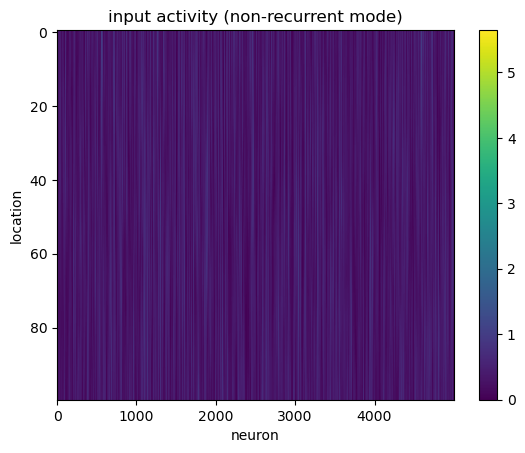

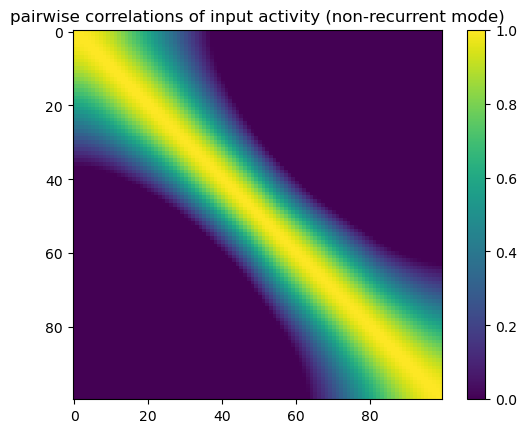

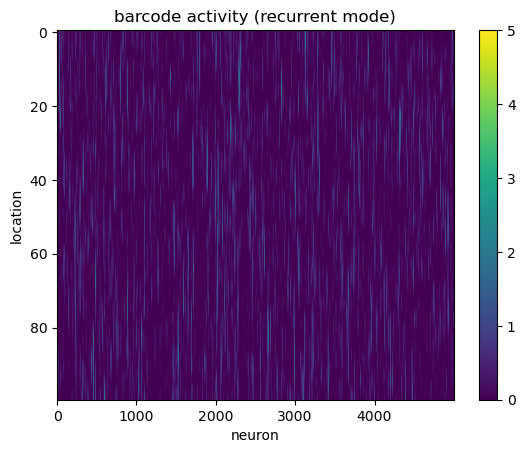

***
sparsity 0.051378


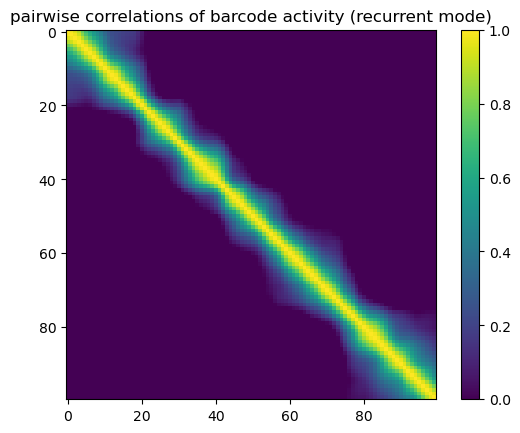

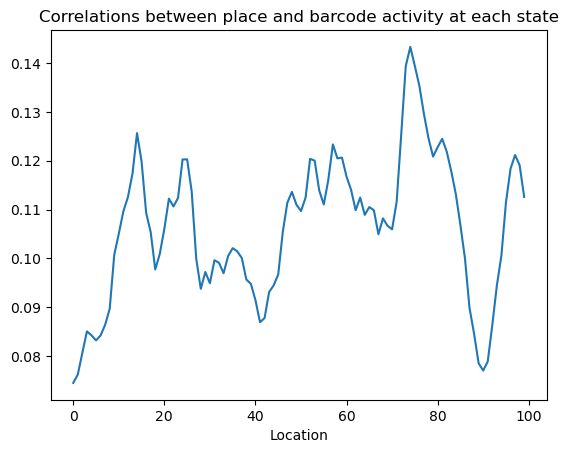

Now I just cached at location: 20


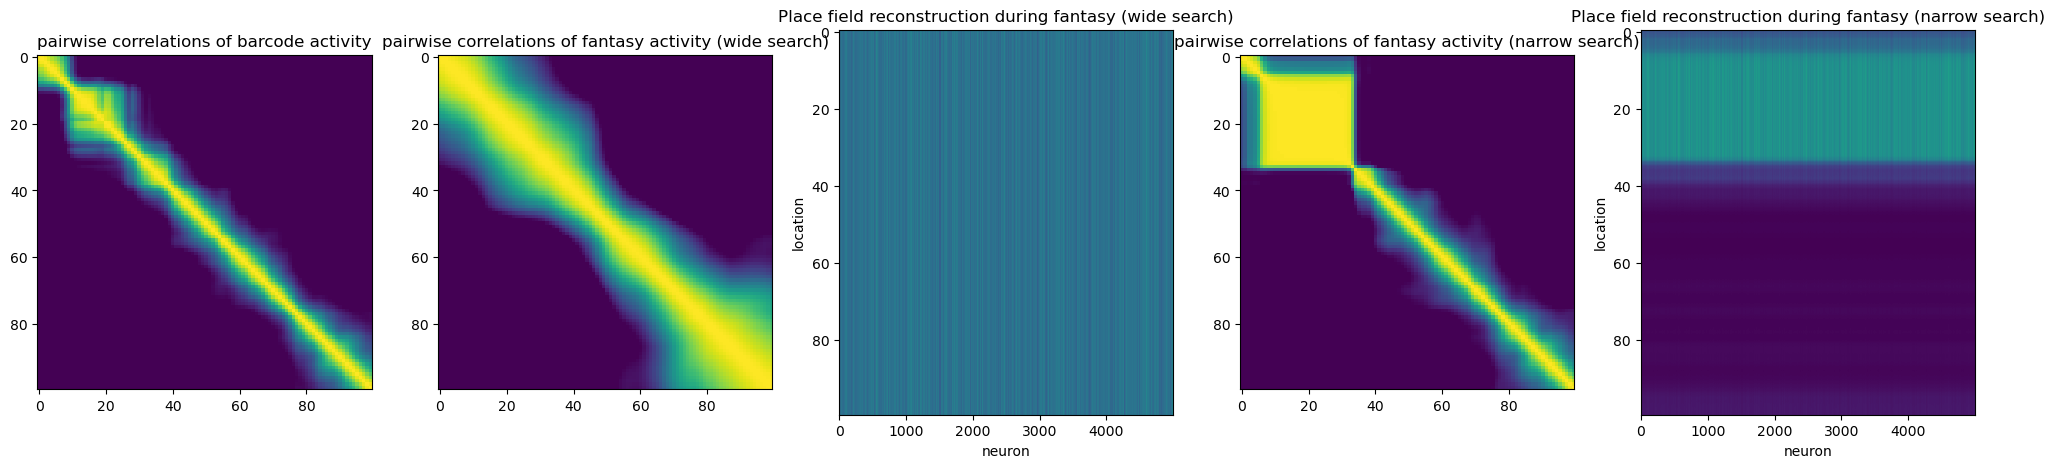

Now I just cached at location: 60


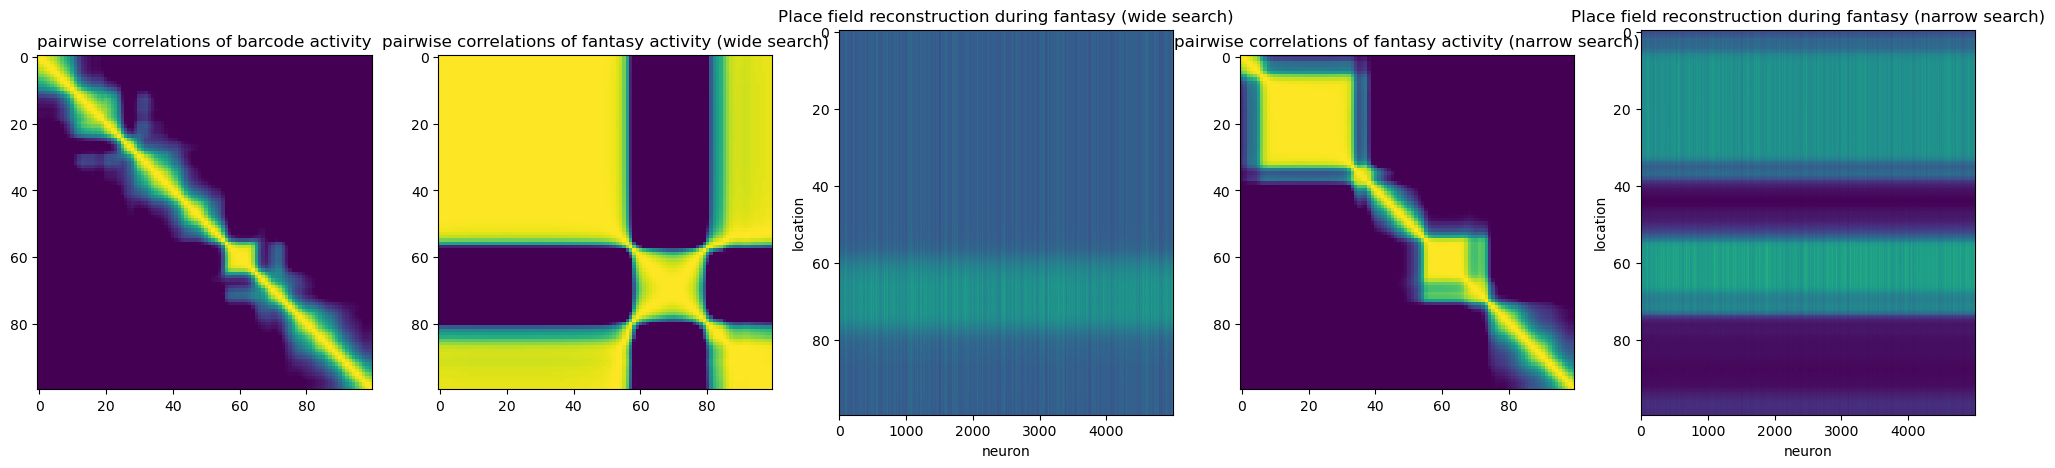

Now I just cached at location: 30


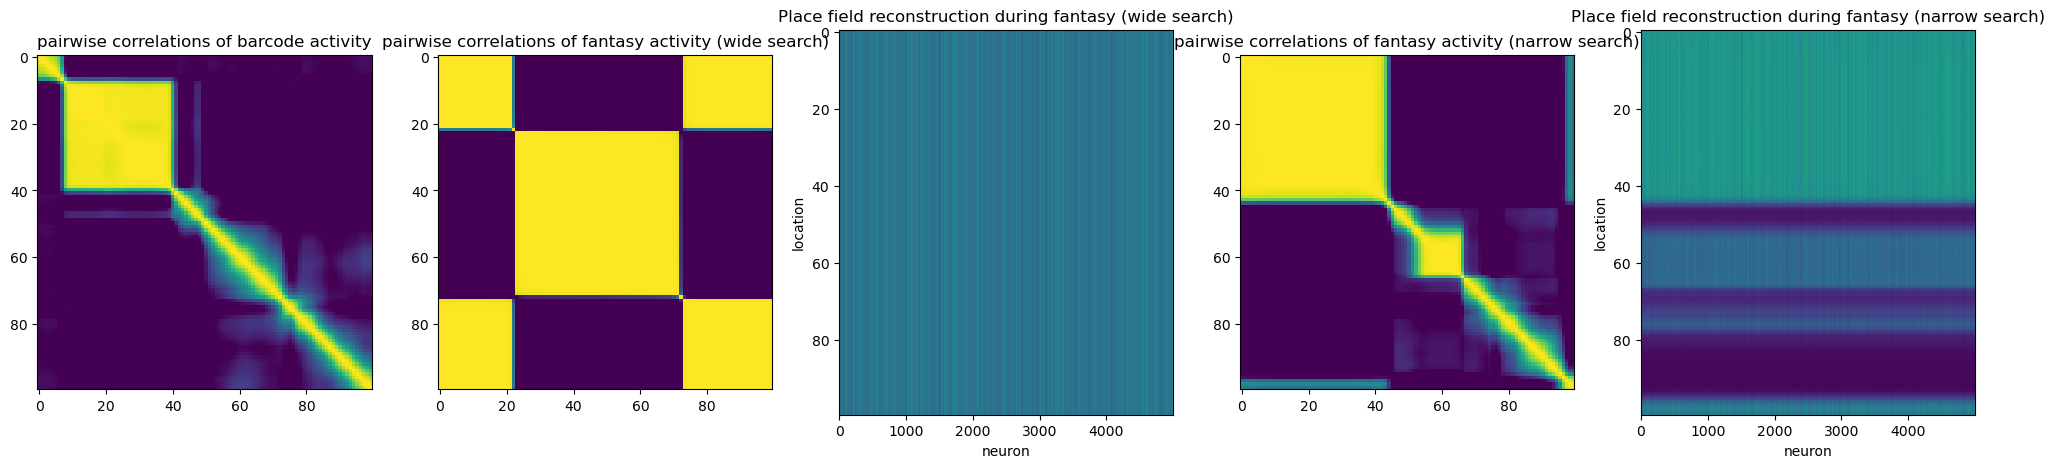

Now I just cached at location: 70


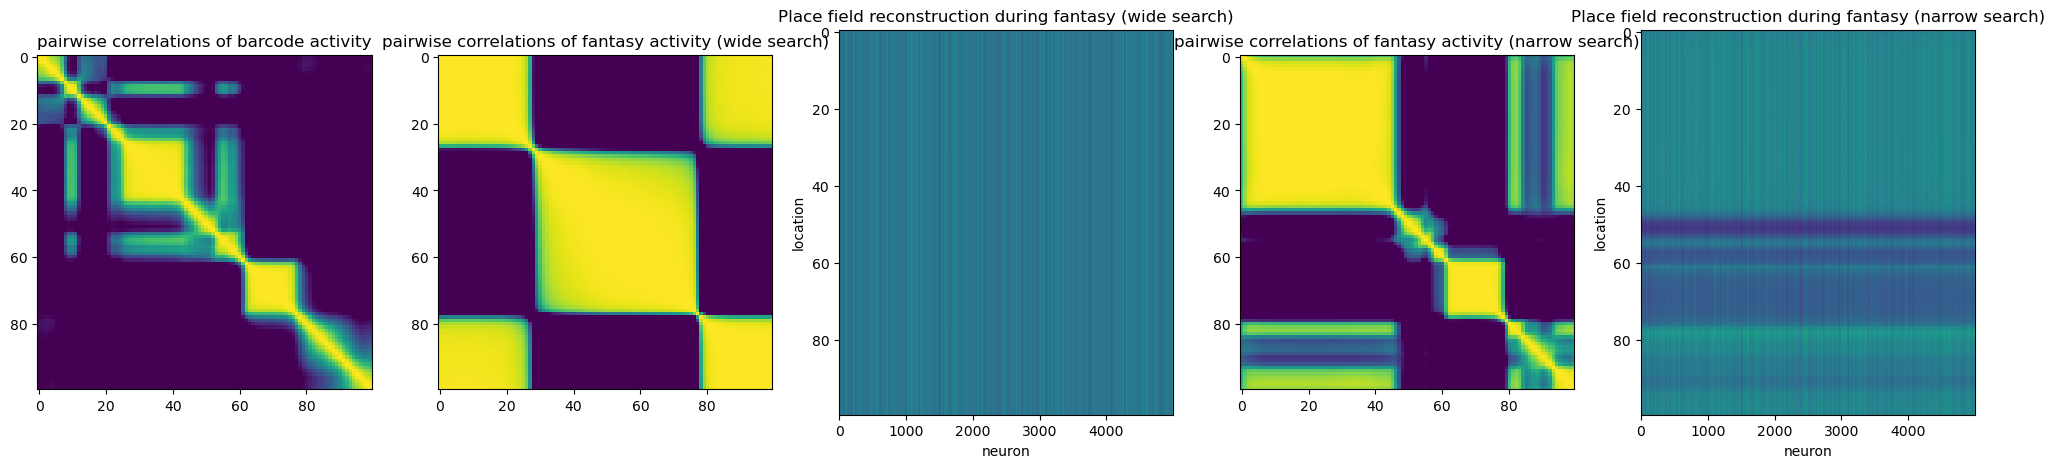

Now I just cached at location: 90


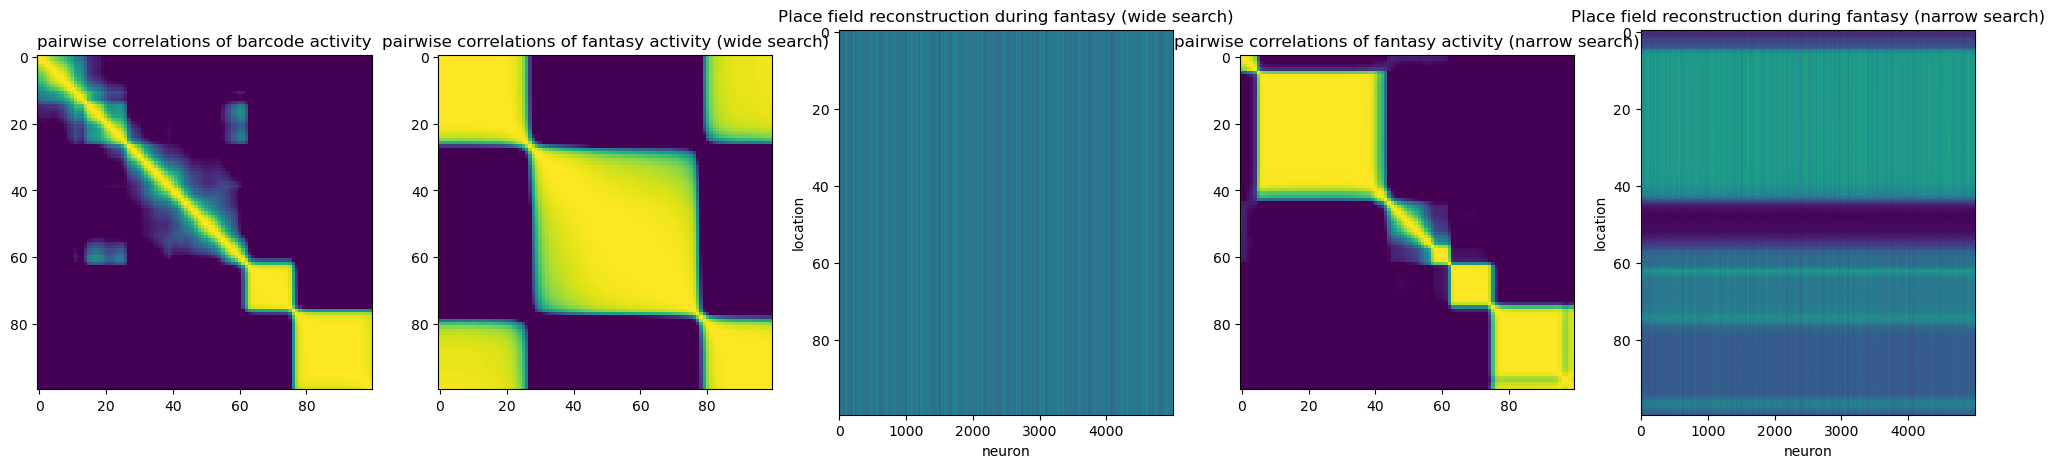

In [28]:
N_inp = 5000
N_bar = 5000

num_states = 100
decay_constant = 0.2
steps = 100
dt = 0.1

inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        inputs[s, n] = np.exp(-(np.abs(n-peak)/(N_inp*decay_constant)))

mixer = np.random.rand(N_inp, N_inp)
mixer[mixer<0.99] = 0
mixer[mixer>0] = 1
mixer /= 20
for row in range(inputs.shape[0]):
    inputs[row] = mixer @ inputs[row]

cache_states = [20,  60, 30, 70, 90]

rec_strength = 1.2
input_strength = 1.0

W_reconstruct = np.zeros([N_inp, N_bar])
rand_J = np.random.randn(N_bar, N_bar)
#rand_J = np.tril(rand_J) + np.tril(rand_J, -1).T
W_rec = rec_strength*(rand_J / np.sqrt(N_bar))# - rec_strength*(0.05 / np.sqrt(N_bar))



b=0.1

W_fantasy = np.zeros([N_bar])

input_act = relu(normalize(inputs), b = b)

plt.imshow(input_act, vmin=0,  aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("input activity (non-recurrent mode)")
plt.show()

input_act = relu(normalize(inputs), b = b)

plt.imshow(pairwise_correlations_centered(input_act), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of input activity (non-recurrent mode)")
plt.show()


preacts, acts = run_dynamics(W_rec, input_strength*inputs+0*W_fantasy, b=b)# relu_cap_adaptive2(0.0*W_fantasy+acts*(1-time_length) + time_length*np.matmul(acts, W_rec)+time_length*inp_strength*inputs, b=b)# p=p)    


plt.imshow(acts, vmin=0, vmax=5, aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("barcode activity (recurrent mode)")
plt.show()

print('***')
print('sparsity', np.mean(acts>0))    
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of barcode activity (recurrent mode)")
plt.show()

acts_normalized = normalize(acts)
inputs_normalized = normalize(input_act)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

narrow_search_factor = -0.05
wide_search_factor = 0.1
suppress_factor = -0.5
lr = 1.0
for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)

    preacts, acts = run_dynamics(W_rec, input_strength*inputs+suppress_factor*W_fantasy, b=b)
    

    

        
    W_fantasy += acts[cache_state]
    act = acts[cache_state:cache_state+1]
    preact = preacts[cache_state:cache_state+1]
    delta_W = np.matmul(act.transpose(), act)
    W_rec += lr * delta_W / N_bar
    W_reconstruct += inputs[cache_state].reshape(-1, 1) @ acts[cache_state].reshape(1, -1)
    
    #W_reconstruct += inputs[cache_state].reshape(-1, 1) @ inputs[cache_state].reshape(1, -1)#acts[cache_state].reshape(1, -1)
    
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs+suppress_factor*W_fantasy, b=b) 
    ax[0].set_title("pairwise correlations of barcode activity")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)

    preacts, acts = run_dynamics(W_rec, input_strength*inputs+wide_search_factor*W_fantasy, b=b) 
    ax[1].set_title("pairwise correlations of fantasy activity (wide search)")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    #reconstruct = np.matmul(inputs, W_reconstruct.transpose())
    ax[2].set_xlabel("neuron")
    ax[2].set_ylabel("location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction during fantasy (wide search)")
    
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs+narrow_search_factor*W_fantasy, b=b) 
    ax[3].set_title("pairwise correlations of fantasy activity (narrow search)")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    

    
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    #reconstruct = np.matmul(inputs, W_reconstruct.transpose())
    ax[4].set_xlabel("neuron")
    ax[4].set_ylabel("location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction during fantasy (narrow search)")
    plt.show()
    